# Audio Input on the fast ADC

This example shows how an audio signal can be captured using the fast input IN2.

Mercury is the Jupyter FPGA overlay for the Red Pitaya.

In [7]:
from redpitaya.overlay.mercury import mercury as overlay
import IPython.display as ipd
import matplotlib.pyplot as plt

fpga = overlay()

Overlay __del__ was activated.
But since there are garbage collection ordering issues, this code is commented out.


Make an instance of the oscilloscope object is used for the input. The first argument is the channel index in range [0,1]. The second argument is the voltage range in volts, should be either 1.0 (default if unspecified) or 20.0. This is set to channel 1 (IN2) and 1.0 Volts the Low setting on the jumper.

In [8]:
in2 = fpga.osc(0, 1.0)

User should specify:
1. Sample rate decimation is an integer in range [1, 2\*\*17] = [1, 131072].
2. Number of samples stored before and after trigger, for a forced trigger only post trigger samples are enough.
3. Input level trigger source should (depending on the test purpose) be disabled (it is enabled by default)

30,000 samples per second is the minimum sample rate IPython.display will support. The minimum was chosen for this example to maximise the recording time using the oscilloscope object buffer.

In [11]:
# data rate decimation 
in2.decimation = 41667 #125 Msps / 41667 = 3 Ksps

# trigger timing [sample periods]
N = in2.buffer_size
in2.trigger_pre  = 0
in2.trigger_post = N

# disable hardware trigger sources - the Jupyter notebook will trigger the start of audio recording
in2.trig_src = 0

The oscilloscope should be reset, started, and a software trigger should be issued.
A loop is checking if the desired number of data samples was already stored in the buffer.

The same number of samples as the sum of pre/post trigger delays should be read from the buffer.
The data read is aligned to the last sample, which will be always present as the last sample in the returned array.

In [18]:
# synchronization and trigger sources are the default,
# which is the module itself
in2.reset()
in2.start()
in2.trigger()
# wait for data
while (in2.status_run()): pass
print ('Recording complete')
data = in2.data(N)

Recording complete


The audio data can then be displayed as an audio file that can be played or downloaded.

In [19]:
sr = 3000 # sample rate 3 Ksps
ipd.Audio(data, rate=sr) # load a NumPy array

Once the recording has been captured it can be displayed as a waveform.

In [ ]:
# show the part of the buffer requested by pre/post trigger timing - in this example the whole buffer.

plt.plot(data)
plt.show()

Audio recorded by the stream server application can be displayed directly in Jupyter using IPython.display.
As the audio file is a WAV file it containts a sampling frequancy.

In [ ]:
sr2 = 43999 # sample rate 48 Ksps
ipd.Audio('/tmp/stream_files/data_file_2022-05-21_11-37-06.wav', rate=sr2) # load a NumPy array

If the sampling frequancy stored in the WAV file is incorrect it can be changed by reading the audio into `numpy` using `pydub`.

If you install `pydub` and `ffmpeg` using the commands `pip install pydub` then `apt-get install ffmpeg` from the console you can use those libraries in Jupyter to work with audio files.

First we will create a function to read in an audio segment.

In [26]:
import pydub 
from pydub import AudioSegment
import numpy as np

def read(file):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_wav(file)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    return np.float32(y) / 2**15

Then we will use the new function to read in a file created by the stream server application.

In [20]:
np_sound = read('/tmp/stream_files/data_file_2022-05-21_15-38-39.wav')

Finally the streamed file can be displayed using `IPython.display`.

In [24]:
ipd.Audio(np_sound, rate=43999)

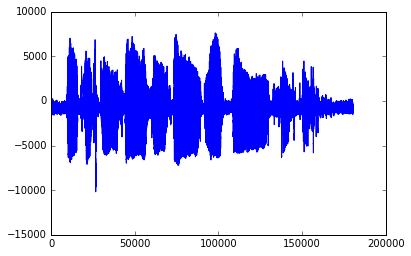

In [22]:
#Plotting the data allows us to check for clipping
data = np_sound
plt.plot(data)
plt.show()

In [30]:
wav_audio = AudioSegment.from_file("/tmp/stream_files/data_file_2022-05-21_20-58-25.wav", format="wav")
frames_per_second = wav_audio.frame_rate
frames_per_second

16384